# Sequential Model

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.convnet import *
from cs231n.solver import Solver
from cs231n.data_utils import get_CIFAR10_data
from cs231n.sequential import *
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'jet'

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Hyper parameter search

In [131]:
data = get_CIFAR10_data()

for n, d in data.items():
    if n.startswith('X'):
        d /= 127.0
    print n, d.shape

num_val = 4000
val_data = {
    'X_train': data['X_train'][:num_val],
    'y_train': data['y_train'][:num_val],
    'X_val': data['X_val'],
    'y_val': data['y_val']
}

X_val (1000, 3, 32, 32)
X_train (49000, 3, 32, 32)
X_test (1000, 3, 32, 32)
y_val (1000,)
y_train (49000,)
y_test (1000,)


In [151]:
results = {}
best_solver = None
best_model = None
best_val_acc = -1

(Iteration 1 / 19600) loss: 2.303035
(Epoch 0 / 20) train acc: 0.109000; val_acc: 0.095000
(Iteration 11 / 19600) loss: 2.303965
(Iteration 21 / 19600) loss: 2.297952
(Iteration 31 / 19600) loss: 2.285494
(Iteration 41 / 19600) loss: 2.207448
(Iteration 51 / 19600) loss: 2.224297
(Iteration 61 / 19600) loss: 2.196580
(Iteration 71 / 19600) loss: 2.154177
(Iteration 81 / 19600) loss: 2.056483
(Iteration 91 / 19600) loss: 2.087325
(Iteration 101 / 19600) loss: 2.027009
(Iteration 111 / 19600) loss: 1.916482
(Iteration 121 / 19600) loss: 1.998605
(Iteration 131 / 19600) loss: 2.270365
(Iteration 141 / 19600) loss: 1.993057
(Iteration 151 / 19600) loss: 2.011322
(Iteration 161 / 19600) loss: 1.851087
(Iteration 171 / 19600) loss: 2.103946
(Iteration 181 / 19600) loss: 1.858205
(Iteration 191 / 19600) loss: 1.942722
(Iteration 201 / 19600) loss: 1.959482
(Iteration 211 / 19600) loss: 2.031116
(Iteration 221 / 19600) loss: 1.965771
(Iteration 231 / 19600) loss: 1.807039
(Iteration 241 / 1960

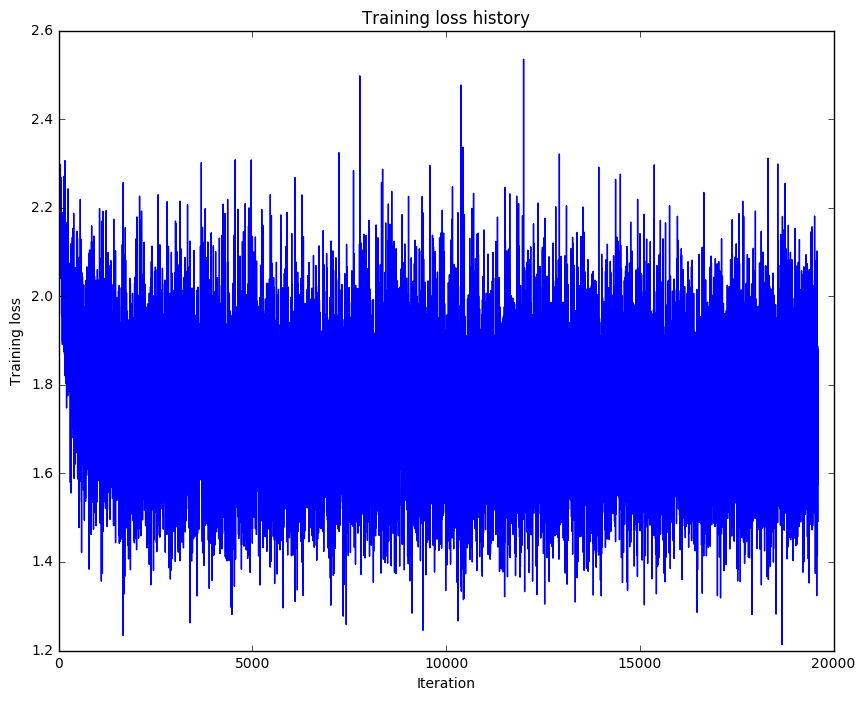

In [162]:
# Hyper parameter search

def uniform(minv, maxv):
    return np.random.rand() * (maxv - minv) + minv

batch_size = 50
batch_shape = (batch_size,) + data['X_train'].shape[1:]

for _ in range(1):
    weight_scale = 1e-3  # 10 ** uniform(-4, -2)
    learning_rate = 10 ** uniform(-1.5, -1)
    reg = 10 ** uniform(-4, -2)
    
    model = Sequential(batch_shape=batch_shape, weight_scale=weight_scale, reg=reg)
    model.add(Dense(num_neurons=100))
    model.add(Dense(num_neurons=10))
    model.build(loss=Softmax())
    
    solver = Solver(model, data,
                    print_every=10, num_epochs=20, batch_size=batch_size,
                    update_rule='sgd',
                    optim_config={
                      'learning_rate': learning_rate,
                    },
                    verbose=True)
    solver.train()
    val_acc = solver.val_acc_history[-1]
    final_loss = solver.loss_history[-1]
    format_str = '{:e} {:e}  final l: {:.5f}  val acc: {}'
    print format_str.format(reg, learning_rate, final_loss, val_acc)
    if final_loss > 10:
        continue
    plt.plot(solver.loss_history, '-')
    results[(reg, learning_rate)] = val_acc
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_solver = solver
        best_model = model

plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

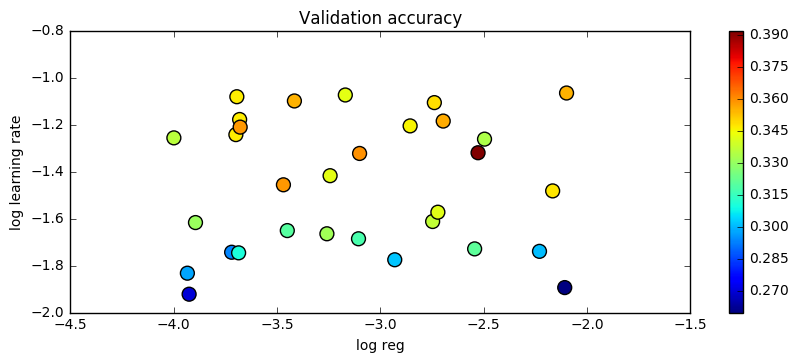

In [163]:
# Visualize the cross-validation results
import math
marker_size = 100
x_scatter, x_label = [np.log10(x[0]) for x in results], 'log reg'
y_scatter, y_label = [np.log10(x[1]) for x in results], 'log learning rate'

# plot validation accuracy
colors = [results[x] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.title('Validation accuracy')
plt.show()

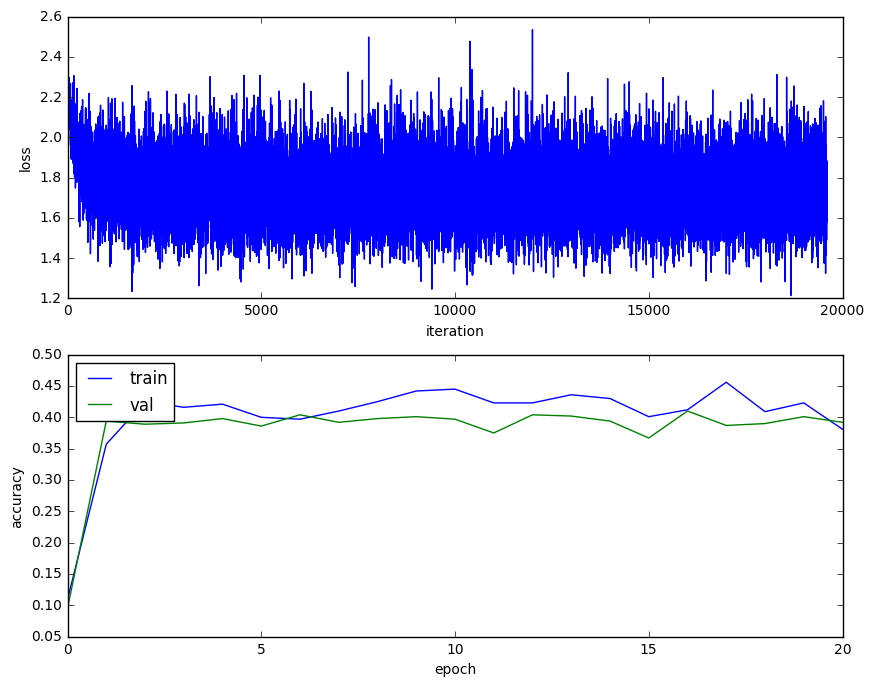

In [164]:
plt.subplot(2, 1, 1)
plt.plot(best_solver.loss_history, '-')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(best_solver.train_acc_history, '-')
plt.plot(best_solver.val_acc_history, '-')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

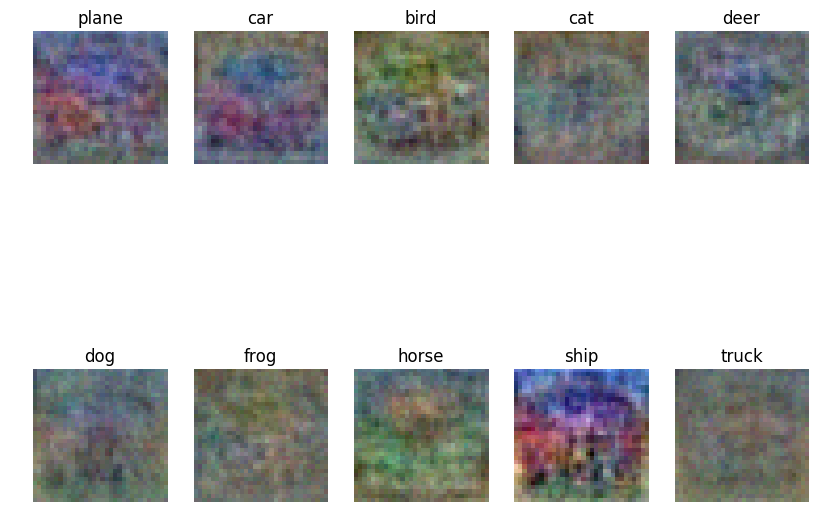

In [160]:
# Visualize the learned weights for each class
w = best_model.params['Dense1_Wb'][:-1,:10] # strip out the bias
w = w.reshape(3, 32, 32, -1)
w = np.moveaxis(w, 0, 2)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in xrange(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])